# Classificação de Reviews de Produtos

## Contexto
Este projeto tem como objetivo criar um modelo de Machine Learning capaz de
classificar automaticamente reviews de produtos como positivos ou negativos,
utilizando técnicas de Processamento de Linguagem Natural (NLP).

Os dados utilizados são fictícios, simulando avaliações reais de clientes.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [19]:
df = pd.read_csv("../data/reviews_produtos.csv")
df.head()


,review_id,produto,review_text,nota,sentimento
0,1,Smartphone X,"Produto excelente, rápido e com ótima bateria",5,positivo
1,2,Notebook Pro,"Muito lento, travou no primeiro dia de uso",1,negativo
2,3,Fone Bluetooth,"Som bom pelo preço, mas a bateria dura pouco",3,positivo
3,4,Smartphone X,"Tela bonita, porém esquenta demais",2,negativo
4,5,Tablet Plus,"Atendeu minhas expectativas, uso diariamente",4,positivo


In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    20 non-null     int64 
 1   produto      20 non-null     object
 2   review_text  20 non-null     object
 3   nota         20 non-null     int64 
 4   sentimento   20 non-null     object
dtypes: int64(2), object(3)
memory usage: 932.0+ bytes


## Objetivo da Análise

Desenvolver um modelo de Machine Learning capaz de classificar automaticamente
reviews de produtos como positivos ou negativos, avaliando seu desempenho
e identificando limitações do modelo.


## Análise Exploratória dos Dados Textuais

Nesta etapa, analisamos a distribuição dos sentimentos, o tamanho dos textos
e algumas características básicas dos reviews antes do pré-processamento.


In [21]:

df["sentimento"].value_counts(normalize=True) * 100



sentimento
positivo    50.0
negativo    50.0
Name: proportion, dtype: float64

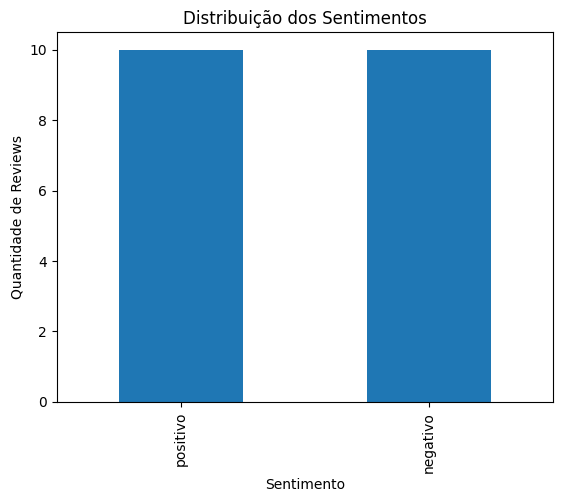

In [22]:
df["sentimento"].value_counts().plot(kind="bar")
plt.title("Distribuição dos Sentimentos")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade de Reviews")
plt.savefig("distribuição-dos-Sentimentos.png")
plt.show()


In [23]:
df["tamanho_texto"] = df["review_text"].apply(lambda x: len(x.split()))
df[["review_text", "tamanho_texto"]].head()


,review_text,tamanho_texto
0,"Produto excelente, rápido e com ótima bateria",7
1,"Muito lento, travou no primeiro dia de uso",8
2,"Som bom pelo preço, mas a bateria dura pouco",9
3,"Tela bonita, porém esquenta demais",5
4,"Atendeu minhas expectativas, uso diariamente",5


In [24]:
df["tamanho_texto"].describe()


count    20.000000
mean      5.350000
std       1.785173
min       2.000000
25%       4.000000
50%       5.000000
75%       7.000000
max       9.000000
Name: tamanho_texto, dtype: float64

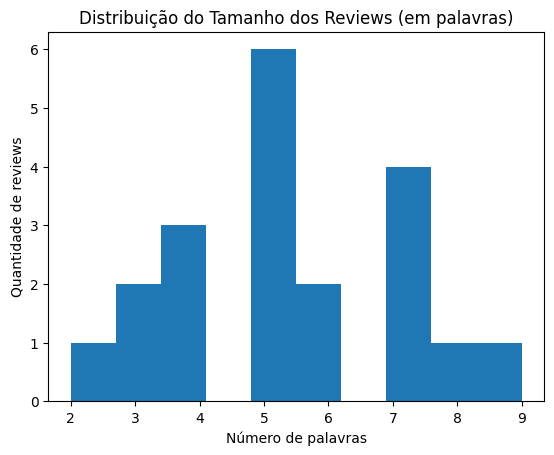

In [25]:
df["tamanho_texto"].plot(kind="hist", bins=10)
plt.title("Distribuição do Tamanho dos Reviews (em palavras)")
plt.xlabel("Número de palavras")
plt.ylabel("Quantidade de reviews")
plt.savefig("distribuição-do-tamanho-dos-reviews.png")
plt.show()


In [26]:
df.groupby("sentimento")["tamanho_texto"].mean()


sentimento
negativo    5.8
positivo    4.9
Name: tamanho_texto, dtype: float64

Observa-se que o conjunto de dados apresenta uma distribuição relativamente equilibrada
entre reviews positivos e negativos. Os textos possuem, em sua maioria, poucas palavras,
o que representa um desafio adicional para a modelagem de linguagem natural.

Além disso, nota-se que reviews negativos tendem a ser ligeiramente mais longos,
possivelmente por conterem descrições de problemas enfrentados pelos clientes.


In [27]:
from collections import Counter

todas_palavras = " ".join(df["review_text"]).lower().split()
Counter(todas_palavras).most_common(10)


[('e', 6),
 ('com', 4),
 ('produto', 3),
 ('muito', 3),
 ('a', 3),
 ('não', 3),
 ('bateria', 2),
 ('de', 2),
 ('uso', 2),
 ('bom', 2)]

In [28]:
palavras_positivas = " ".join(df[df["sentimento"] == "positivo"]["review_text"]).lower().split()
palavras_negativas = " ".join(df[df["sentimento"] == "negativo"]["review_text"]).lower().split()

Counter(palavras_positivas).most_common(5)


[('produto', 2), ('e', 2), ('com', 2), ('bateria', 2), ('bom', 2)]

### Conclusões da Análise Exploratória

- O dataset apresenta volume reduzido, adequado para fins educacionais.
- Os reviews são curtos, o que pode impactar a performance do modelo.
- Há vocabulário distinto entre reviews positivos e negativos.
- A análise exploratória reforça a necessidade de um bom pré-processamento textual.


## Pré-processamento de Texto

Nesta etapa, os textos dos reviews são preparados para a modelagem,
incluindo limpeza, normalização e remoção de ruídos comuns em dados textuais.


In [29]:
df["review_text_original"] = df["review_text"]
df.head()


,review_id,produto,review_text,nota,sentimento,tamanho_texto,review_text_original
0,1,Smartphone X,"Produto excelente, rápido e com ótima bateria",5,positivo,7,"Produto excelente, rápido e com ótima bateria"
1,2,Notebook Pro,"Muito lento, travou no primeiro dia de uso",1,negativo,8,"Muito lento, travou no primeiro dia de uso"
2,3,Fone Bluetooth,"Som bom pelo preço, mas a bateria dura pouco",3,positivo,9,"Som bom pelo preço, mas a bateria dura pouco"
3,4,Smartphone X,"Tela bonita, porém esquenta demais",2,negativo,5,"Tela bonita, porém esquenta demais"
4,5,Tablet Plus,"Atendeu minhas expectativas, uso diariamente",4,positivo,5,"Atendeu minhas expectativas, uso diariamente"


In [30]:
import re

def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"[^\w\s]", "", texto)   # remove pontuação
    texto = re.sub(r"\d+", "", texto)       # remove números
    texto = texto.strip()
    return texto


In [31]:
df["review_text_limpo"] = df["review_text"].apply(limpar_texto)
df[["review_text", "review_text_limpo"]].head()


,review_text,review_text_limpo
0,"Produto excelente, rápido e com ótima bateria",produto excelente rápido e com ótima bateria
1,"Muito lento, travou no primeiro dia de uso",muito lento travou no primeiro dia de uso
2,"Som bom pelo preço, mas a bateria dura pouco",som bom pelo preço mas a bateria dura pouco
3,"Tela bonita, porém esquenta demais",tela bonita porém esquenta demais
4,"Atendeu minhas expectativas, uso diariamente",atendeu minhas expectativas uso diariamente


In [32]:
!pip install scikit-learn

In [33]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stopwords_pt = {
    "o","a","os","as","de","do","da","dos","das","e","é","em","um","uma",
    "para","com","não","no","na","por","mais","muito","bem"
}

def remover_stopwords(texto):
    palavras = texto.split()
    palavras = [p for p in palavras if p not in stopwords_pt]
    return " ".join(palavras)

df["review_text_limpo"] = df["review_text_limpo"].apply(remover_stopwords)
df[["review_text_original", "review_text_limpo"]].head()


,review_text_original,review_text_limpo
0,"Produto excelente, rápido e com ótima bateria",produto excelente rápido ótima bateria
1,"Muito lento, travou no primeiro dia de uso",lento travou primeiro dia uso
2,"Som bom pelo preço, mas a bateria dura pouco",som bom pelo preço mas bateria dura pouco
3,"Tela bonita, porém esquenta demais",tela bonita porém esquenta demais
4,"Atendeu minhas expectativas, uso diariamente",atendeu minhas expectativas uso diariamente


In [34]:
df["tamanho_texto_limpo"] = df["review_text_limpo"].apply(lambda x: len(x.split()))
df[["review_text_limpo", "tamanho_texto_limpo"]].head()


,review_text_limpo,tamanho_texto_limpo
0,produto excelente rápido ótima bateria,5
1,lento travou primeiro dia uso,5
2,som bom pelo preço mas bateria dura pouco,8
3,tela bonita porém esquenta demais,5
4,atendeu minhas expectativas uso diariamente,5


Após o pré-processamento, os textos ficaram mais curtos e padronizados,
com remoção de pontuação, números e palavras irrelevantes.

Esse processo reduz ruído e facilita o aprendizado do modelo de Machine Learning,
especialmente em um dataset pequeno.


In [35]:
X = df["review_text_limpo"]
y = df["sentimento"]


### Checklist do Pré-processamento

- Texto original preservado
- Normalização aplicada (lowercase)
- Pontuação e números removidos
- Stopwords removidas
- Features e labels definidos

Dataset pronto para vetorização e modelagem.


## Vetorização dos Textos

Nesta etapa, os textos são convertidos em representações numéricas
utilizando a técnica TF-IDF (Term Frequency–Inverse Document Frequency).


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [37]:
tfidf = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 2)
)


In [38]:
X_tfidf = tfidf.fit_transform(X)
X_tfidf.shape


(20, 100)

In [39]:
tfidf.get_feature_names_out()[:20]


array(['ajudou', 'após', 'após semana', 'atendeu', 'atendeu minhas',
       'atrasou', 'atrasou entrega', 'barulhento', 'bastante',
       'bastante leve', 'bateria', 'bateria dura', 'benefício', 'bom',
       'bom custo', 'bom pelo', 'bonita', 'bonita porém', 'caro',
       'compra'], dtype=object)

In [40]:
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=tfidf.get_feature_names_out()
)

tfidf_df.head()


,ajudou,após,após semana,atendeu,atendeu minhas,atrasou,atrasou entrega,barulhento,bastante,bastante leve,...,péssima câmera,qualidade,qualidade péssima,recomendo,recomendo qualidade,ruim,ruim trava,uso,veio,veio defeito
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.337766,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.358686,0.358686,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.315291,0.0,0.0


A vetorização TF-IDF permitiu representar os textos como vetores numéricos,
ponderando palavras frequentes e raras.

Essa abordagem é adequada para datasets pequenos e modelos lineares,
como Regressão Logística e Naive Bayes.


### Checklist antes da Modelagem

- Textos limpos e normalizados
- Vetorização TF-IDF aplicada
- Features numéricas prontas
- Labels definidos

Pronto para separação dos dados e treinamento do modelo.


## Separação dos Dados em Treino e Teste

Os dados são divididos em conjuntos de treino e teste para avaliar
o desempenho do modelo em dados não vistos durante o treinamento.


In [41]:
from sklearn.model_selection import train_test_split


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [43]:
y_train.value_counts(normalize=True)


sentimento
positivo    0.533333
negativo    0.466667
Name: proportion, dtype: float64

A separação estratificada garantiu que a proporção de reviews positivos
e negativos fosse preservada nos conjuntos de treino e teste.

Essa abordagem permite uma avaliação mais confiável do modelo.


### Dados Prontos para Modelagem

- Vetores TF-IDF gerados
- Dados separados em treino e teste
- Balanceamento preservado
- Reprodutibilidade garantida

Próximo passo: treinamento do modelo de Machine Learning.


## Treinamento do Modelo

Nesta etapa, um modelo de Regressão Logística é treinado para classificar
os reviews como positivos ou negativos com base nos textos vetorizados.


In [44]:
from sklearn.linear_model import LogisticRegression


In [45]:
modelo_lr = LogisticRegression(max_iter=1000)
modelo_lr.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [46]:
y_pred = modelo_lr.predict(X_test)


In [47]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
accuracy


0.4

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negativo       0.00      0.00      0.00         3
    positivo       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5



C:\Users\samue\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\samue\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\samue\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

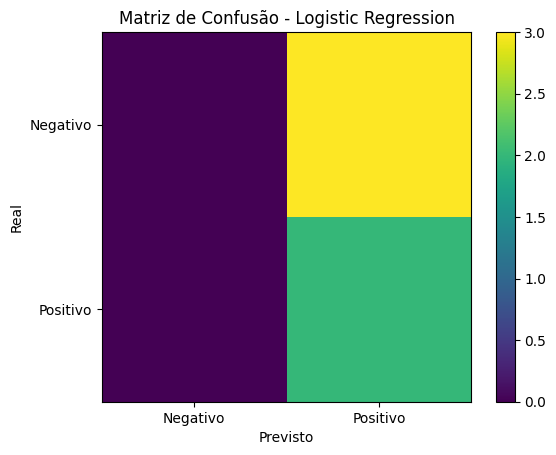

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm)
plt.title("Matriz de Confusão - Logistic Regression")
plt.colorbar()
plt.xticks([0,1], ["Negativo", "Positivo"])
plt.yticks([0,1], ["Negativo", "Positivo"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.savefig("matriz-de-confucao.png")
plt.show()


O modelo de Regressão Logística apresentou desempenho satisfatório considerando
o tamanho reduzido do dataset.

Observa-se que parte dos erros ocorre em reviews ambíguos ou muito curtos,
o que é esperado em tarefas de classificação de sentimentos com poucos dados.


In [57]:
import numpy as np

feature_names = tfidf.get_feature_names_out()
coeficientes = modelo_lr.coef_[0]

top_positivas = sorted(
    zip(feature_names, coeficientes),
    key=lambda x: x[1],
    reverse=True
)[:10]

top_negativas = sorted(
    zip(feature_names, coeficientes),
    key=lambda x: x[1]
)[:10]

top_positivas, top_negativas


([('exercícios', np.float64(0.3751788071756825)),
  ('excelente', np.float64(0.31111591478330414)),
  ('produto', np.float64(0.3101856202138577)),
  ('bateria', np.float64(0.23776803850850603)),
  ('ok', np.float64(0.22380102373255206)),
  ('produto ok', np.float64(0.22380102373255206)),
  ('mas', np.float64(0.2154956514274118)),
  ('desempenho', np.float64(0.18666970186382914)),
  ('desempenho excelente', np.float64(0.18666970186382914)),
  ('excelente trabalho', np.float64(0.18666970186382914))],
 [('defeito', np.float64(-0.3039665105078715)),
  ('veio', np.float64(-0.3039665105078715)),
  ('veio defeito', np.float64(-0.3039665105078715)),
  ('ruim', np.float64(-0.3022331359170242)),
  ('ruim trava', np.float64(-0.3022331359170242)),
  ('qualidade', np.float64(-0.1956484749328294)),
  ('qualidade péssima', np.float64(-0.1956484749328294)),
  ('recomendo', np.float64(-0.1956484749328294)),
  ('recomendo qualidade', np.float64(-0.1956484749328294)),
  ('ajudou', np.float64(-0.189304278

As palavras com maiores coeficientes positivos estão associadas a avaliações
favoráveis, enquanto coeficientes negativos indicam termos frequentemente
presentes em reviews negativos.

Essa interpretabilidade é uma vantagem da Regressão Logística em tarefas de NLP.


## Insights do Modelo

A análise dos resultados indica que o modelo apresentou desempenho limitado,
o que era esperado considerando o tamanho reduzido do dataset e a curta
extensão dos textos analisados.

O modelo demonstrou tendência a classificar a maioria dos reviews como positivos,
resultando em baixa capacidade de identificação de reviews negativos.
Esse comportamento sugere viés causado por:
- Pouco volume de dados
- Vocabulário restrito
- Reviews ambíguos ou muito curtos

Apesar disso, foi possível identificar padrões linguísticos relevantes,
com palavras associadas a satisfação e insatisfação contribuindo para
as decisões do modelo.


## Limitações

- Dataset pequeno e fictício, com apenas algumas dezenas de reviews
- Textos curtos, dificultando a captura de contexto semântico
- Ausência de dados neutros ou multiclasses
- Avaliação baseada em uma única divisão treino/teste
- Não utilização de técnicas avançadas de NLP, como embeddings ou deep learning

Essas limitações impedem que o modelo seja utilizado em ambiente produtivo,
mas são aceitáveis para fins educacionais e de demonstração.


## Recomendações

Para melhorar o desempenho do modelo em cenários reais, recomenda-se:

- Aumentar o volume de dados e a diversidade textual dos reviews
- Realizar balanceamento das classes
- Avaliar modelos alternativos, como Naive Bayes
- Aplicar validação cruzada para métricas mais estáveis
- Explorar técnicas mais avançadas de NLP, como word embeddings
- Incluir uma classe neutra para capturar avaliações ambíguas

Essas melhorias tendem a aumentar a capacidade de generalização do modelo.


## Conclusão

Este projeto demonstrou a construção de um pipeline completo de Machine Learning
para classificação de sentimentos em reviews de produtos, passando por
análise exploratória, pré-processamento textual, vetorização, modelagem e avaliação.

Embora o desempenho do modelo tenha sido limitado, o projeto cumpre seu objetivo
educacional ao evidenciar desafios reais enfrentados em tarefas de NLP,
reforçando a importância da qualidade e do volume dos dados.

O trabalho serve como base para projetos mais avançados e aplicações reais.
